# Explore how to pull out HOPE look directions

In [1]:
%matplotlib inline
#%matplotlib notebook
%load_ext version_information
%load_ext autoreload


In [2]:
import datetime
import os
import sys
import warnings

warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import spacepy.datamodel as dm
import spacepy.plot as spp
import spacepy.time as spt
import spacepy.pycdf as pycdf
import spacepy.toolbox as tb
import spacepy.pycdf as pycdf
import path
import tqdm
import pandas as pd
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import norm
from scipy import constants

import spiceypy as spice

%version_information matplotlib, numpy, spacepy, pandas, spiceypy

Software versions
Python 3.6.1 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 6.1.0
OS Darwin 15.6.0 x86_64 i386 64bit
matplotlib 2.0.2
numpy 1.11.3
spacepy UNRELEASED
pandas 0.20.1
spiceypy 2.0.0
Thu Jul 13 08:37:19 2017 AKDT

In [3]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['savefig.dpi'] = plt.rcParams['figure.dpi'] # 72
%config InlineBackend.figure_format = 'retina'

In [4]:
EARTH_RAD = 6378137/1e3 # WGS84 km

WGS84_A = 6378.1370    #           // semi-major axis of earth (equatorial radius) in km
WGS84_A2 = 40680631.59076899 #      // WGS84_A * WGS84_A (km^2)
WGS84_A2mB2 = 272331.6066819355 #      // WGS84_A2 - WGS84_B2 (km^2)
WGS84_B = 6356.7523142      #      // semi-minor axis of earth (polar radius) in km ( derived from b=a(1-f) )
WGS84_B2 = 40408299.98408706  #     // WGS84_B * WGS84_B (km^2)
WGS84_A2mB2 = 272331.6066819355 #      // WGS84_A2 - WGS84_B2 (km^2)

In [5]:
l1fname = 'rbspa_int_ect-hope-sci-L1_20161210_v1.1.0.cdf'
# l1 = dm.fromCDF(l1fname)
l2 = dm.fromCDF('rbspa_int_ect-hope-sci-L2_20161210_v5.2.0.cdf')
l2.tree(verbose=1)

+
|____Acquisition_Period (spacepy.pycdf.VarCopy (7612,))
|____B_Calc_Ele (spacepy.pycdf.VarCopy (4138,))
|____B_Calc_Ion (spacepy.pycdf.VarCopy (3474,))
|____B_Eq_Ele (spacepy.pycdf.VarCopy (4138,))
|____B_Eq_Ion (spacepy.pycdf.VarCopy (3474,))
|____Detector_LABL (spacepy.pycdf.VarCopy (5,))
|____ENERGY_Ele_DELTA (spacepy.pycdf.VarCopy (4138, 72))
|____ENERGY_Ion_DELTA (spacepy.pycdf.VarCopy (3474, 72))
|____ESA_Polarity (spacepy.pycdf.VarCopy (7612,))
|____ESA_Sweep (spacepy.pycdf.VarCopy (7612,))
|____ESA_Volt (spacepy.pycdf.VarCopy (7612, 72))
|____ESA_Volt_LABL_1 (spacepy.pycdf.VarCopy (72,))
|____Energy_Collapsed (spacepy.pycdf.VarCopy (7612,))
|____Energy_LABL (spacepy.pycdf.VarCopy (72,))
|____Epoch (spacepy.pycdf.VarCopy (7612,))
|____Epoch_Ele (spacepy.pycdf.VarCopy (4138,))
|____Epoch_Ele_DELTA (spacepy.pycdf.VarCopy (4138,))
|____Epoch_Ion (spacepy.pycdf.VarCopy (3474,))
|____Epoch_Ion_DELTA (spacepy.pycdf.VarCopy (3474,))
|____FEDU (spacepy.pycdf.VarCopy (4138, 5, 16, 72))

In [6]:
# load up the spice kernel
print(spice.tkvrsn("TOOLKIT"))
spice.furnsh("package/20161210_kern.ker")

CSPICE_N0066


In [7]:
# get the position and veloicity for all the Epoch_Ion times in the file
Epoch_Ion = np.asarray([v.isoformat() for v in np.asarray(l2['Epoch_Ion'])])
spicetimes = np.asarray([spice.str2et(v) for v in Epoch_Ion])
positions, lightTimes = spice.spkpos('RBSP_A', spicetimes, 'J2000', 'NONE', 'EARTH')
altitudes = positions - WGS84_A
altitude = norm(altitudes, axis=1)
radius = norm(positions, axis=1)

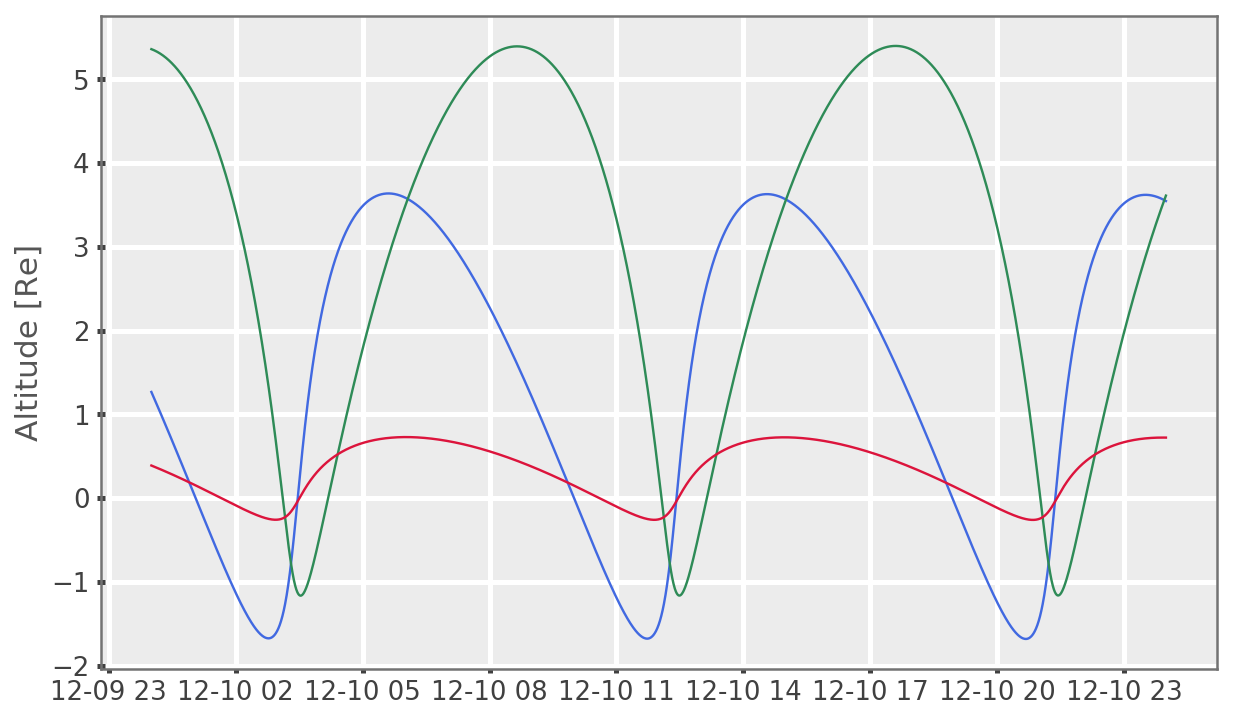

In [8]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, sharex=True)
ax1.plot(l2['Epoch_Ion'], positions/WGS84_A)
ax1.set_ylabel('Altitude [Re]')




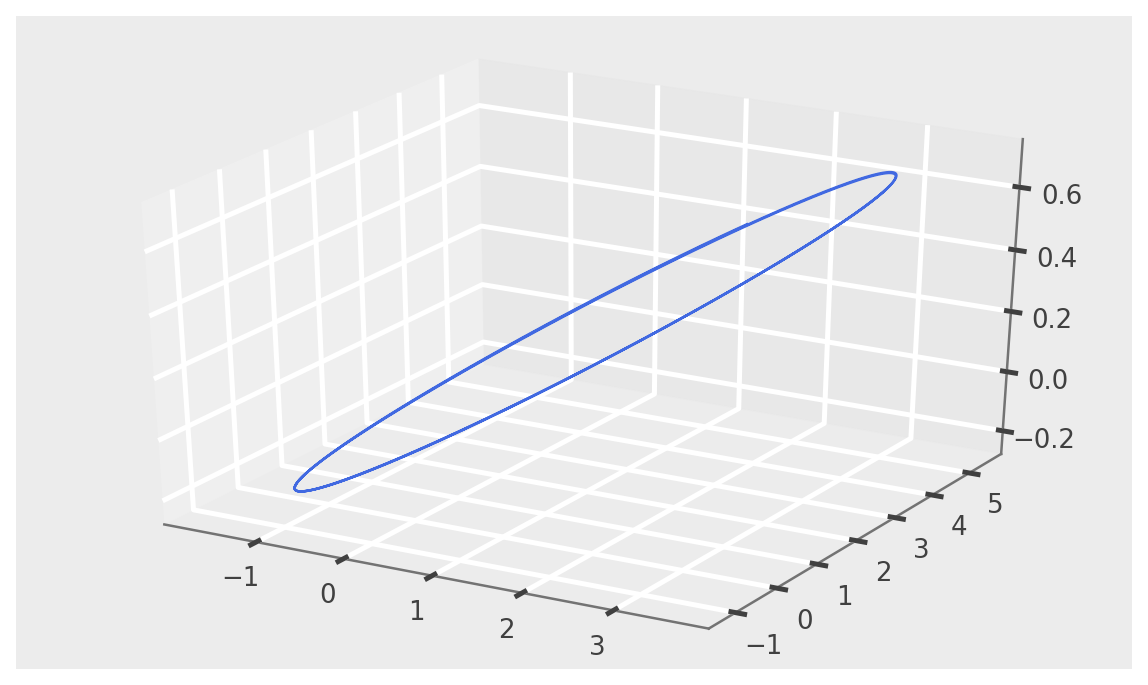

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(positions[:,0]/WGS84_A, positions[:,1]/WGS84_A, positions[:,2]/WGS84_A)


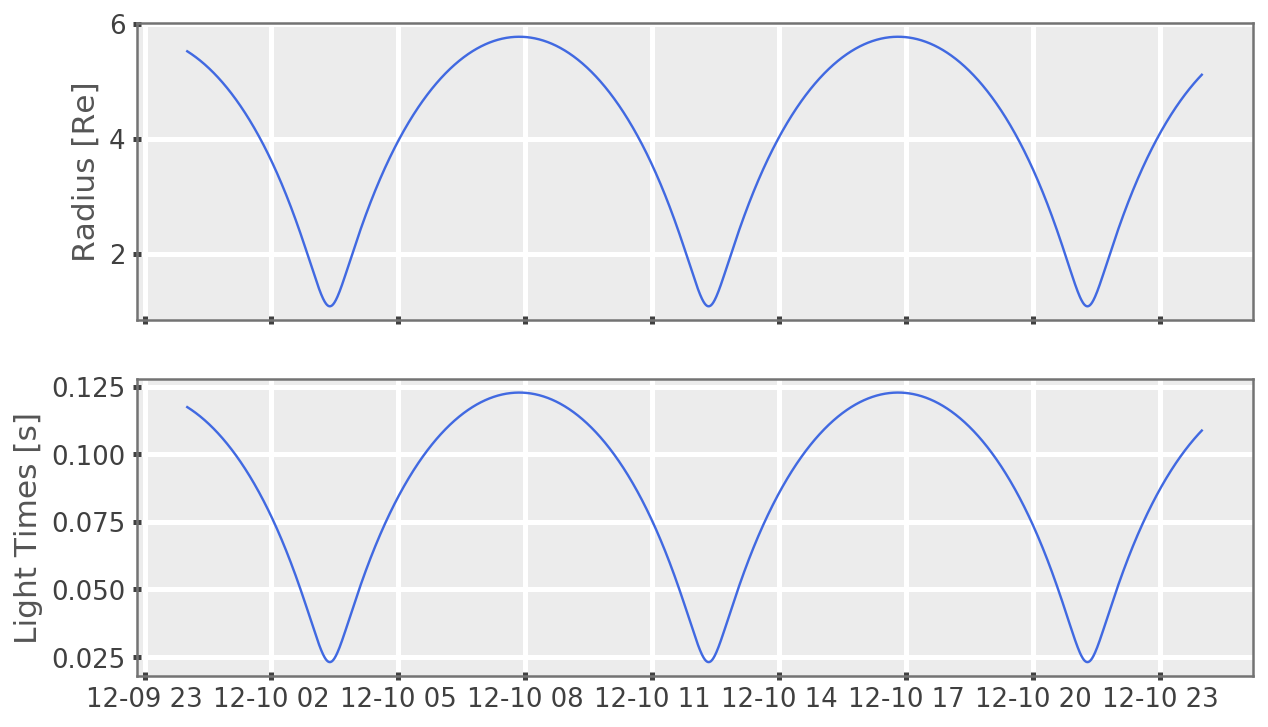

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True)

ax1.plot(l2['Epoch_Ion'], radius/WGS84_A)
ax1.set_ylabel('Radius [Re]')

ax2.plot(l2['Epoch_Ion'], lightTimes)
ax2.set_ylabel('Light Times [s]')


In [11]:
# get the position and veloicity for all the Epoch_Ion times in the file
Epoch_Ion = np.asarray([v.isoformat() for v in np.asarray(l2['Epoch_Ion'])])
spicetimes = np.asarray([spice.str2et(v) for v in Epoch_Ion])
positions = np.empty((len(Epoch_Ion), 3), dtype=float)
velocities = np.empty((len(Epoch_Ion), 3), dtype=float)
lightTimes = np.empty((len(Epoch_Ion)), dtype=float)

for ii, val in enumerate(tqdm.tqdm(spicetimes)):
    pv, lightTimes[ii] = spice.spkezr('RBSP_A', val, 'J2000', 'NONE', 'EARTH')
    positions[ii] = pv[:3]
    velocities[ii] = pv[3:]


100%|██████████| 3474/3474 [00:00<00:00, 31940.67it/s]


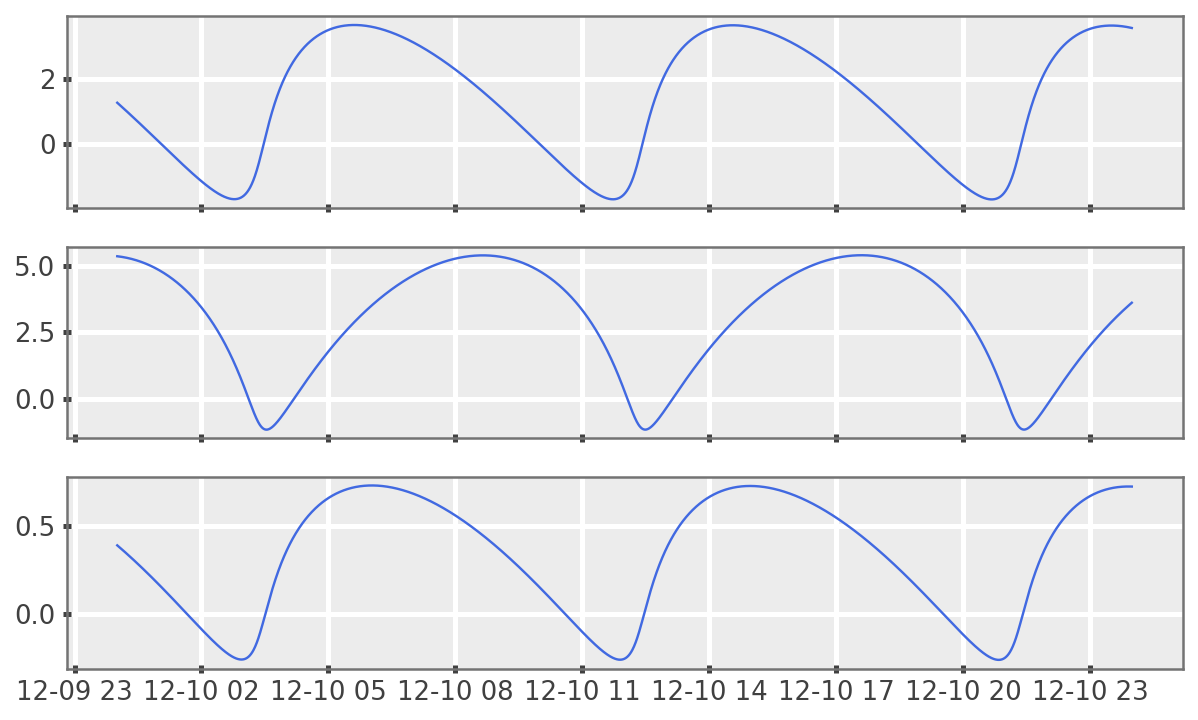

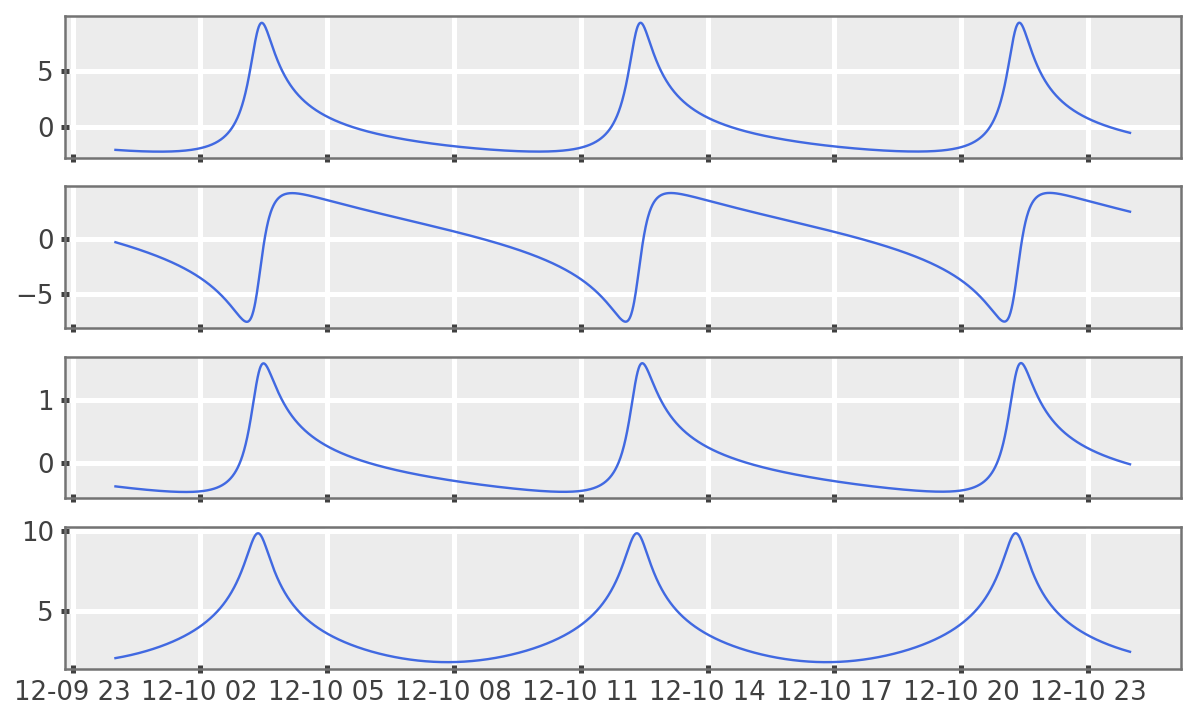

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, sharex=True)

ax1.plot(l2['Epoch_Ion'], positions[:,0]/WGS84_A)
ax2.plot(l2['Epoch_Ion'], positions[:,1]/WGS84_A)
ax3.plot(l2['Epoch_Ion'], positions[:,2]/WGS84_A)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=1, nrows=4, sharex=True)

ax1.plot(l2['Epoch_Ion'], velocities[:,0])
ax2.plot(l2['Epoch_Ion'], velocities[:,1])
ax3.plot(l2['Epoch_Ion'], velocities[:,2])
ax4.plot(l2['Epoch_Ion'], norm(velocities, axis=1))


In [13]:
# need rotation matrix from RBSPA_SPACECRAFT to RBSPA_SCIENCE at each step


rotations = np.empty((len(Epoch_Ion), 3, 3), dtype=float)

for ii, val in enumerate(tqdm.tqdm(spicetimes)):
    rotations[ii] = spice.pxform('J2000', 'RBSPA_SCIENCE', val)



100%|██████████| 3474/3474 [00:00<00:00, 10134.42it/s]


In [14]:
rotations[0], rotations[100]

(array([[ 0.91871119, -0.3200888 ,  0.23132858],
        [-0.23946611,  0.01428821,  0.97079958],
        [-0.31404734, -0.94727979, -0.06352368]]),
 array([[-0.2289231 ,  0.14065871, -0.9632286 ],
        [ 0.92135477, -0.28803994, -0.26103328],
        [-0.31416492, -0.94723182, -0.06365758]]))

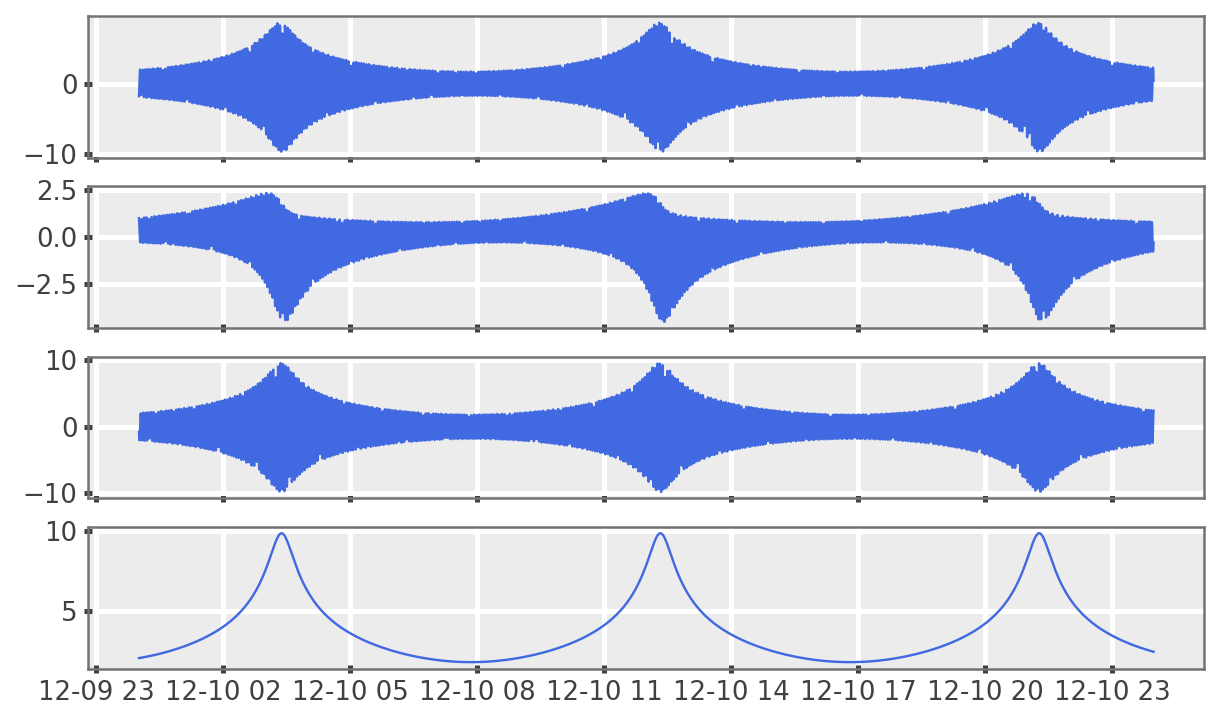

In [15]:
v_sci = np.zeros_like(velocities)    
    
for ii, val in enumerate(velocities):
    v_sci[ii] = np.dot(velocities[ii], rotations[ii])
    
    
    
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=1, nrows=4, sharex=True)

ax1.plot(l2['Epoch_Ion'], v_sci[:,0])
ax2.plot(l2['Epoch_Ion'], v_sci[:,1])
ax3.plot(l2['Epoch_Ion'], v_sci[:,2])
ax4.plot(l2['Epoch_Ion'], norm(v_sci, axis=1))

# ax2.plot(l2['Epoch_Ion'], velocities[:,1])
# ax3.plot(l2['Epoch_Ion'], velocities[:,2])
# ax4.plot(l2['Epoch_Ion'], norm(velocities, axis=1))


# We belive the above to be correct
-> Not clear how to validate that we are not off by 180

### Can we speed up the rotations with np.einsum?
Yes, we can, einsum is a lot faster

In [16]:
v_sci = np.zeros_like(velocities)    
    
for ii, val in enumerate(velocities):
    v_sci[ii] = np.dot(velocities[ii], rotations[ii])
    
print(v_sci.shape)
print(v_sci[0:4])    

print(np.einsum('ij,ijk->ik',velocities,rotations).shape)
print(np.einsum('ij,ijk->ik',velocities,rotations)[0:4])

(3474, 3)
[[-1.68370763  0.99401606 -0.77218577]
 [-0.82314959  0.77651221 -1.77500096]
 [ 0.43197927  0.3779328  -2.02824659]
 [ 1.55694891 -0.03494702 -1.42479638]]
(3474, 3)
[[-1.68370763  0.99401606 -0.77218577]
 [-0.82314959  0.77651221 -1.77500096]
 [ 0.43197927  0.3779328  -2.02824659]
 [ 1.55694891 -0.03494702 -1.42479638]]


In [17]:
%timeit np.einsum('ij,ijk->ik',velocities,rotations)

133 µs ± 1.96 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%timeit for ii, val in enumerate(velocities): v_sci[ii] = np.dot(velocities[ii], rotations[ii])

10.3 ms ± 334 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## The rotate the RBSPA_SCIENCE frame into each HOPE pixel

In [19]:
# rotations from UVW to HOPE (UVW is RBSPA_SCIENCE in spice)
# These are taken from the HOPE Pitch angle code

# these have to be transposed because SPICE does rotation matrices
# indexed by [output dimension, input dimension]
# where lanlgeomag indexed by [input, output]
hope1_rot = np.matrix([[0.30432233, 0.17364818, 0.93660783],
                       [-0.05366024, 0.98480775, -0.16514923],
                       [-0.95105652, 0., 0.30901699]]).transpose()
hope2_rot = np.matrix([[0.79672621, 0.17364818, 0.57885547],
                       [-0.14048433, 0.98480775, -0.10206784],
                       [-0.58778525, 0., 0.80901699]]).transpose()
# 80 degree rotation around z
hope3_rot = np.matrix([[0.98480775, 0.17364818, 0.],
                       [-0.17364818, 0.98480775, 0.],
                       [0., 0., 1.]]).transpose()
hope4_rot = np.matrix([[0.79672621, 0.17364818, -0.57885547],
                       [-0.14048433, 0.98480775, 0.10206784],
                       [0.58778525, 0., 0.80901699]]).transpose()
hope5_rot = np.matrix([[0.30432233, 0.17364818, -0.93660783],
                       [-0.05366024, 0.98480775, 0.16514923],
                       [0.95105652, 0., 0.30901699]]).transpose()

rots = (hope1_rot, hope2_rot, hope3_rot, hope4_rot, hope5_rot)
rotnp = np.asarray(rots)
# spin axis is omega
# compute omega in uvw
sc_uvw_rot = np.matrix([[0.81915204, -0.57357644, 0.],
                        [0.57357644, 0.81915204, 0.],
                        [-0., 0., 1.]])
# omega is along Z in xyz and uvw!!  But leave this in for tuning
omega_uvw = np.asarray((np.array([0, 0, 1]) * sc_uvw_rot))[0]


In [20]:
pixel_velocities = np.empty((len(velocities), 3, 5), dtype=float)
for pixel in tqdm.tqdm(range(5)):
    pixel_velocities[:,:,pixel] = np.asarray(v_sci*rots[pixel])

100%|██████████| 5/5 [00:00<00:00, 2243.18it/s]


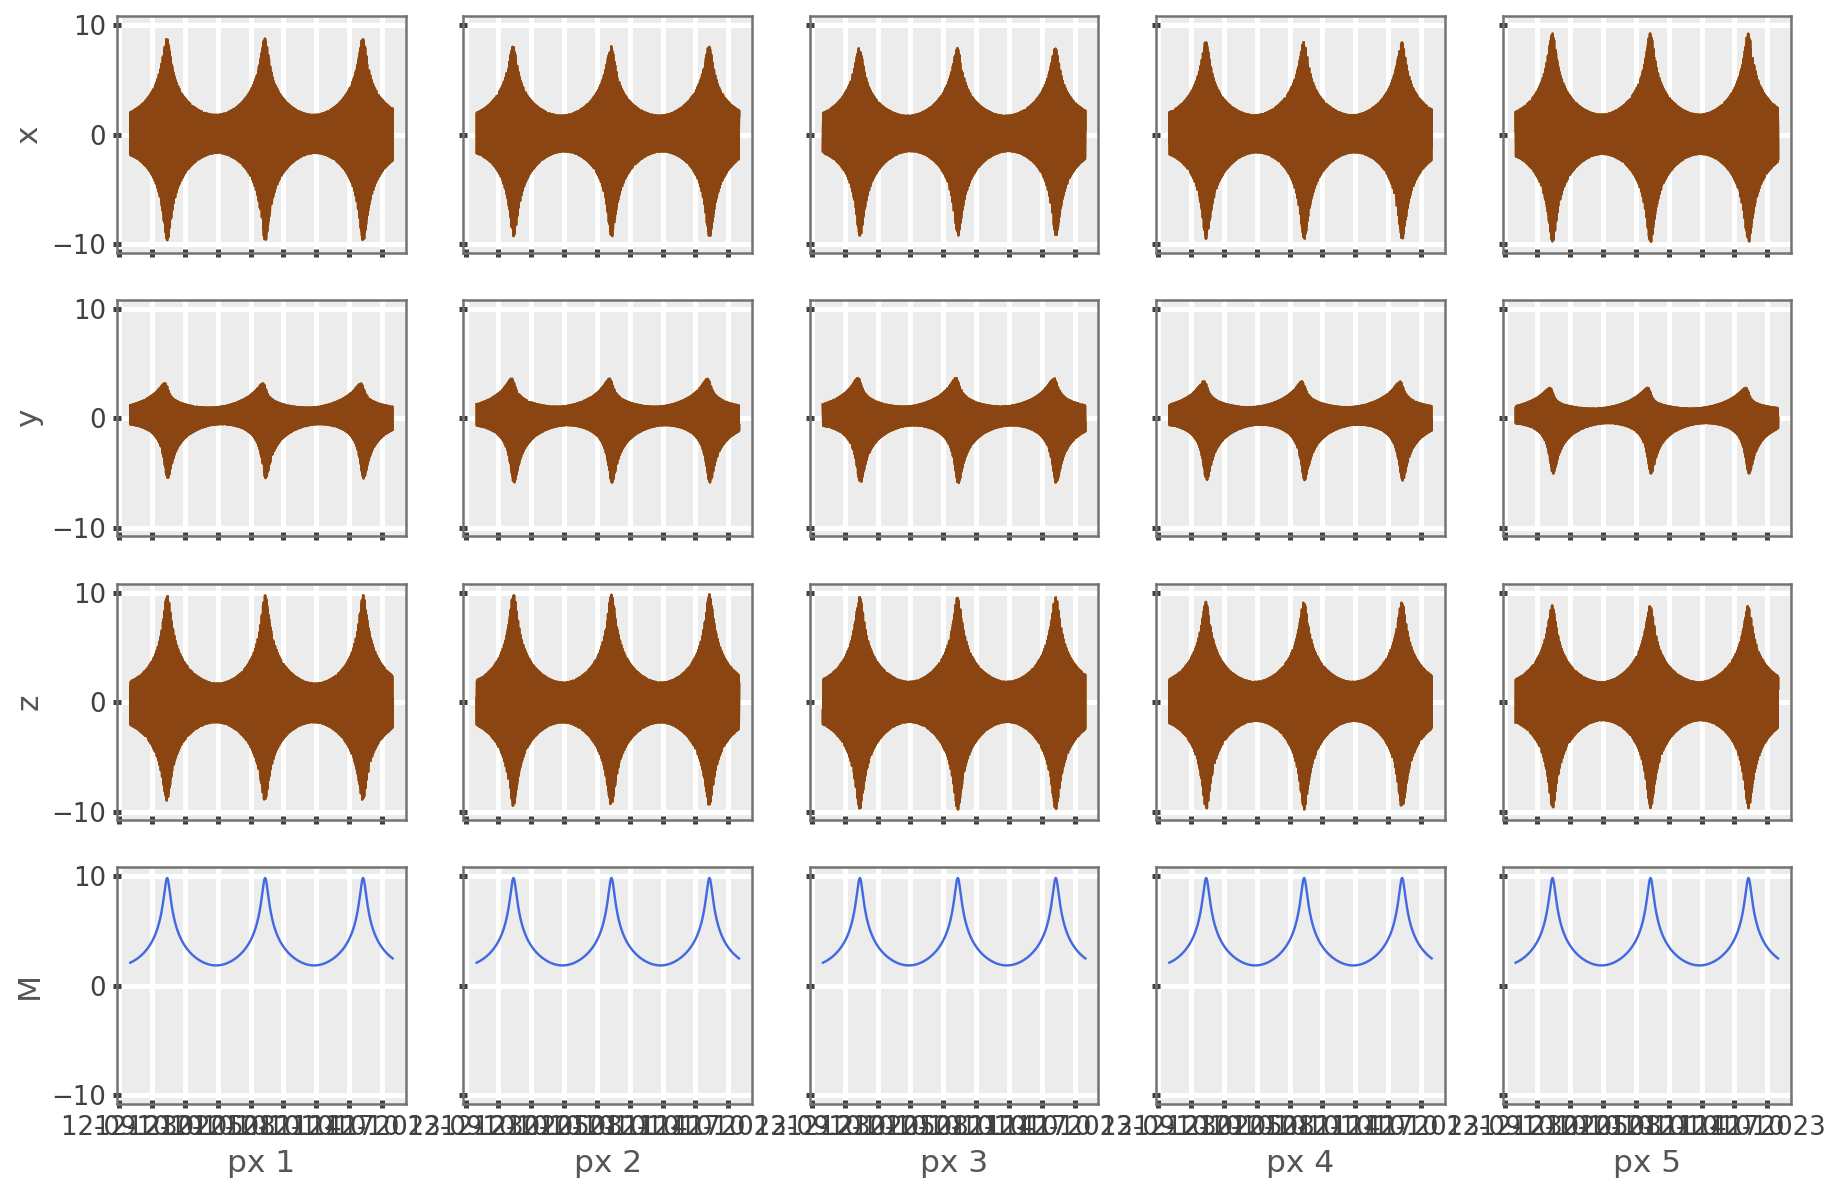

In [21]:

fig, ax = plt.subplots(ncols=5, nrows=4, sharex=True, sharey=True, figsize=(15,10))
components = ('x', 'y', 'z', 'M')

for comp in range(4):
    for pix in range(5):
        if comp < 3:
            ax[comp][pix].plot(l2['Epoch_Ion'], pixel_velocities[:,comp,pix])
            ax[comp][pix].plot(l2['Epoch_Ion'], pixel_velocities[:,comp,pix])
            ax[comp][pix].plot(l2['Epoch_Ion'], pixel_velocities[:,comp,pix])
            ax[comp][pix].plot(l2['Epoch_Ion'], pixel_velocities[:,comp,pix])
            ax[comp][pix].plot(l2['Epoch_Ion'], pixel_velocities[:,comp,pix])
        else:
            ax[comp][pix].plot(l2['Epoch_Ion'], norm(pixel_velocities[:,:,pix], axis=1))
        ax[-1][pix].set_xlabel('px {0}'.format(pix+1))
    ax[comp][0].set_ylabel('{0}'.format(components[comp]))

(736308.1666666666, 736308.1805555555)

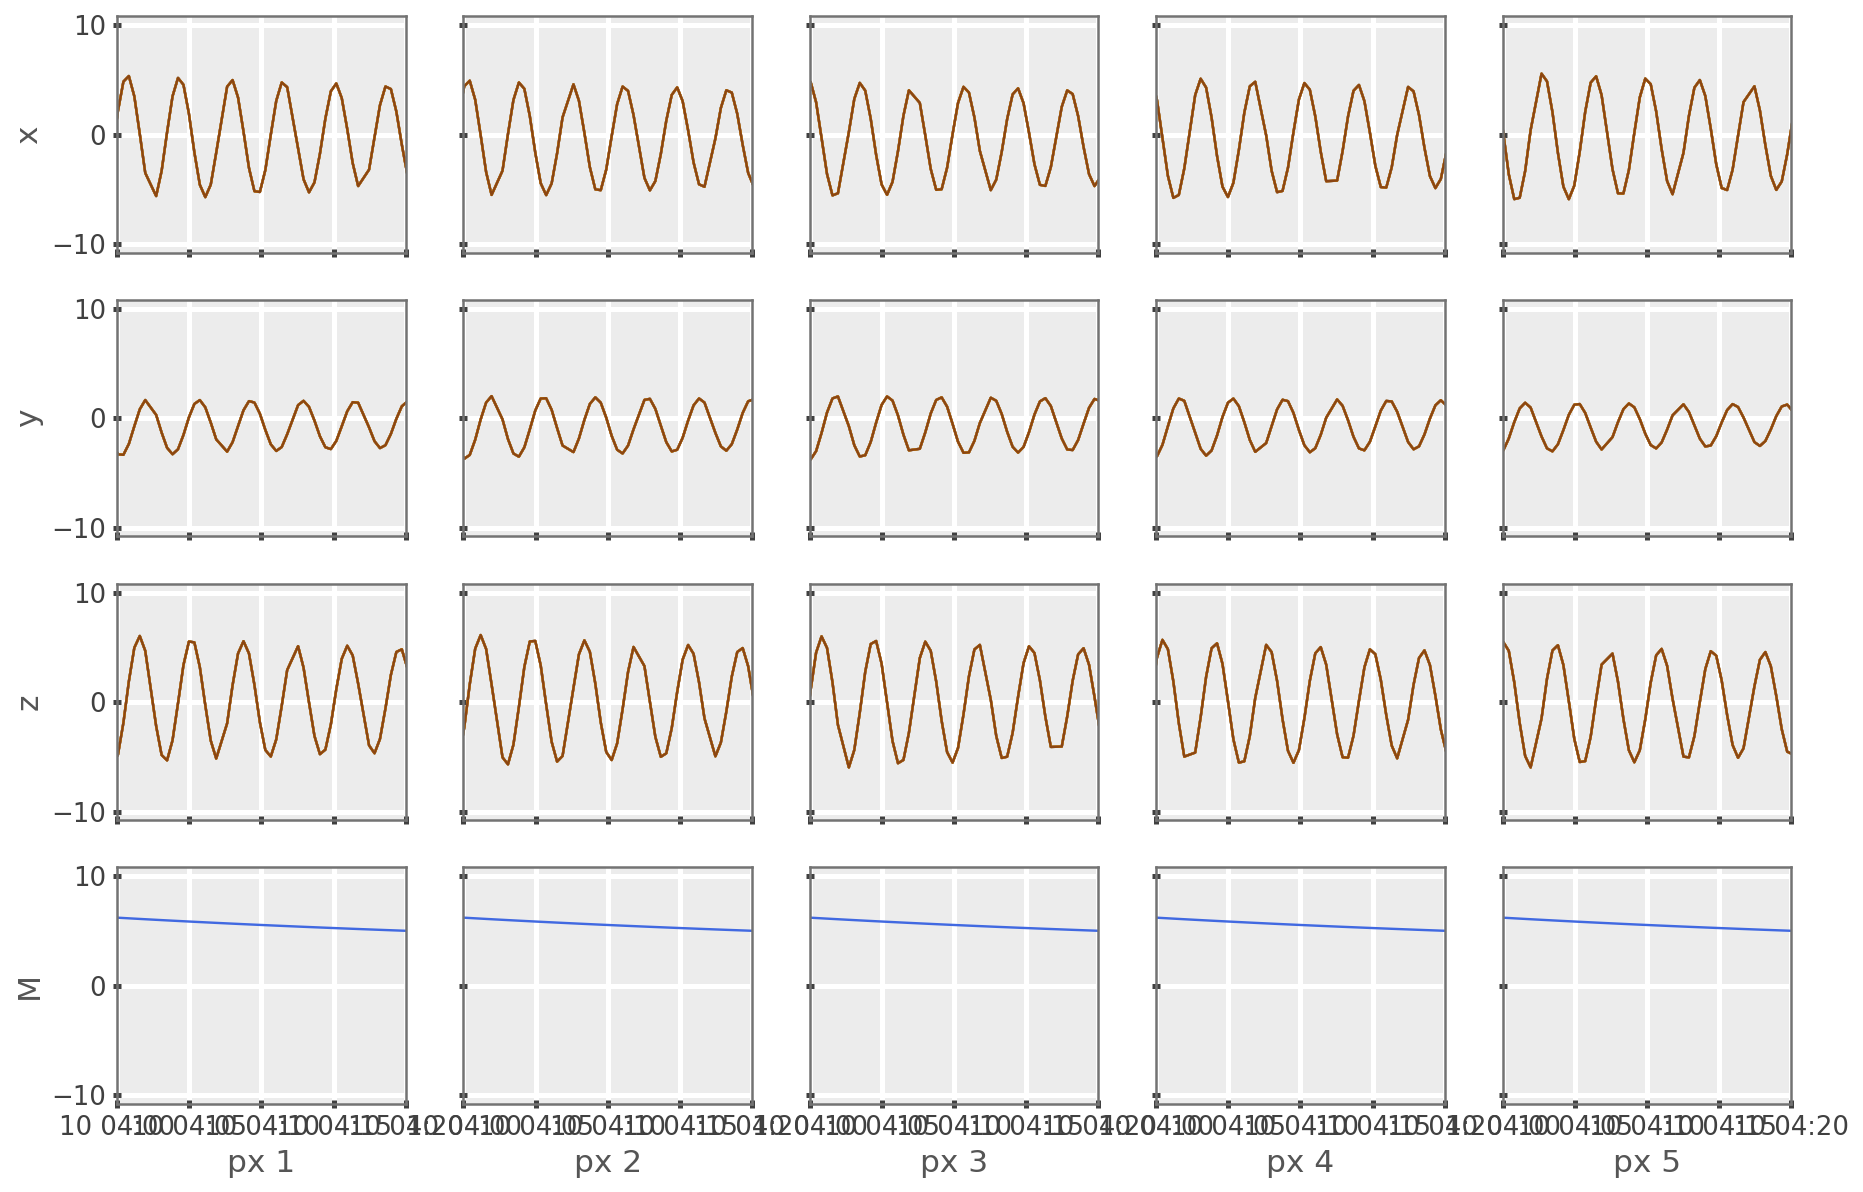

In [22]:

fig, ax = plt.subplots(ncols=5, nrows=4, sharex=True, sharey=True, figsize=(15,10))
components = ('x', 'y', 'z', 'M')

for comp in range(4):
    for pix in range(5):
        if comp < 3:
            ax[comp][pix].plot(l2['Epoch_Ion'], pixel_velocities[:,comp,pix])
            ax[comp][pix].plot(l2['Epoch_Ion'], pixel_velocities[:,comp,pix])
            ax[comp][pix].plot(l2['Epoch_Ion'], pixel_velocities[:,comp,pix])
            ax[comp][pix].plot(l2['Epoch_Ion'], pixel_velocities[:,comp,pix])
            ax[comp][pix].plot(l2['Epoch_Ion'], pixel_velocities[:,comp,pix])
        else:
            ax[comp][pix].plot(l2['Epoch_Ion'], norm(pixel_velocities[:,:,pix], axis=1))
        ax[-1][pix].set_xlabel('px {0}'.format(pix+1))
    ax[comp][0].set_ylabel('{0}'.format(components[comp]))
plt.xlim((datetime.datetime(2016, 12, 10, 4), datetime.datetime(2016, 12, 10, 4, 20)))

# Work out the velocity correction by species

$E=\frac{1}{2}mv^2$

$v=\sqrt{\frac{2E}{m}}$

In [23]:
masses = {'H':938.2720813e6, 'He':3728.401e6, 'O':14899.17e6}  # eV/c**2

In [108]:
def kms_to_c(kms):
    """
    change km/s into a fraction of c
    """
    return kms*1e3/constants.c

print(kms_to_c(3e8/1e3), kms_to_c(10/1e3))

def kms_to_e(kms, species='H'):
    """
    change km/s into energy for the species
    """
    return np.sign(kms)*0.5*masses[species]*kms_to_c(kms)**2
    
print(kms_to_e(10, 'H'), kms_to_e(10, 'He'), kms_to_e(10, 'O'))
print(kms_to_e(-10, 'H'), kms_to_e(-10, 'He'), kms_to_e(-10, 'O'))

1.0006922855944562 3.3356409519815205e-08
0.521984241926 2.07420279082 8.28878116783
-0.521984241926 -2.07420279082 -8.28878116783


## Copied in from pitch_angle_lib.py in pitch_angle
Likely should be some kind of import

The unit vectors for each telescope is $[1,0,0]$ pointed out of the telescope. In the pitch angle code there is a -1 because particles go into telescopes. We will have to work to validate this here to make sure we have the right sign and not off by 180. 

In [25]:

def makeFullTimes_Ele(L1cdf, TagTimes):
    """
    go through and make the full time arrays
    """
    # raw read the Epoch!!  This is faster and in milliseconds so no conversion needed
    epoch16 = L1cdf.raw_var('Epoch_Elc_Cntr_e')[...]
    TagTimes['Epoch_Ele'] = dm.dmarray([pycdf.lib.epoch16_to_epoch(v) for v in epoch16])
    TagTimes['Epoch_Ele'].attrs = L1cdf['Epoch_Elc_Cntr_e'].attrs.copy()
    # (3879,)

    # if they are actually all the same no need to cycle through here
    if (L1cdf['FRAME_subtime'][:, 0, 0] != L1cdf['FRAME_subtime'][:, 0, 0][0]).any():
        raise(NotImplementedError("L1cdf['FRAME_subtime'] has different values, not sure what to do"))

    TagTimes['Epoch_Ele_FRAME_subtime'] = L1cdf['FRAME_subtime'][0, :, :].copy()
    # (16, 72)
    # L2cdf['FEDU'] CDF_REAL4 [3879, 5, 16, 72]
    ## multiply TagTimes['Epoch_Ele_FRAME_subtime'] by 1000 to make it a Epoch (milliseconds)
    TagTimes['Epoch_Ele_FRAME_subtime'] *= 1000

    ## make the full times as Epochs
    # Full times needs [epoch][sector][energy]  NO PIXEL!!
    # factor of 4 in time by not having it be [pixel] also (8 to 2 seconds)
    # also cdf is 140M smaller!!!
    TagTimes['Full_times_Ele'] = np.empty((L1cdf['Elc_Cntr_e'].shape[0],
                                           L1cdf['Elc_Cntr_e'].shape[2],
                                           L1cdf['Elc_Cntr_e'].shape[3]), dtype=np.float64)

    for ii, epoch in enumerate(TagTimes['Epoch_Ele']):
        TagTimes['Full_times_Ele'][ii] = epoch + TagTimes['Epoch_Ele_FRAME_subtime']


def makeFullTimes_Ion(L1cdf, TagTimes):
    """
    go through and make the full time arrays
    """
    # raw read the Epoch!!  This is faster and in milliseconds so no conversion needed
    epoch16 = L1cdf.raw_var('Epoch_Ion_Cntr_H')[...]
    # (3879,)
    TagTimes['Epoch_Ion'] = dm.dmarray([pycdf.lib.epoch16_to_epoch(v) for v in epoch16])
    TagTimes['Epoch_Ion'].attrs = L1cdf['Epoch_Ion_Cntr_H'].attrs.copy()

    # if they are actually all the same no need to cycle through here
    if (L1cdf['FRAME_subtime'][:, 0, 0] != L1cdf['FRAME_subtime'][:, 0, 0][0]).any():
        raise(NotImplementedError("L1cdf['FRAME_subtime'] has different values, not sure what to do"))

    TagTimes['Epoch_Ion_FRAME_subtime'] = L1cdf['FRAME_subtime'][0, :, :].copy()
    # (16, 72)
    # L2cdf['FEDU'] CDF_REAL4 [3879, 5, 16, 72]
    ## multiply TagTimes['Epoch_Ion_FRAME_subtime'] by 1000 to make it a Epoch (milliseconds)
    TagTimes['Epoch_Ion_FRAME_subtime'] *= 1000

    ## make the full times as Epochs
    # Full times needs [epoch][sector][energy]  NO PIXEL!!
    # factor of 4 in time by not having it be [pixel] also (8 to 2 seconds)
    # also cdf is 140M smaller!!!
    TagTimes['Full_times_Ion'] = np.empty((L1cdf['Ion_Cntr_H'].shape[0],
                                           L1cdf['Ion_Cntr_H'].shape[2],
                                           L1cdf['Ion_Cntr_H'].shape[3]), dtype=np.float64)

    for ii, epoch in enumerate(TagTimes['Epoch_Ion']):
        TagTimes['Full_times_Ion'][ii] = epoch + TagTimes['Epoch_Ion_FRAME_subtime']



## Convert times from CDF to unix seconds
UNX: Unix Time (Posix Time) seconds since 1970-Jan-1 (not counting leap seconds)

CDF: Return CDF time which is milliseconds since 01-Jan-0000 00:00:00.000. “Year zero” is a convention chosen by NSSDC to measure epoch values. This date is more commonly referred to as 1 BC. Remember that 1 BC was a leap year. The CDF date/time calculations do not take into account the changes to the Gregorian calendar, and cannot be directly converted into Julian date/times.

JD: elapsed days since 12:00 January 1, 4713 BC


In [27]:
print(datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=1.352e9))


2012-11-04 03:33:20


In [28]:
tt = pd.DatetimeIndex(freq='1h', start=datetime.datetime(2010, 10, 1), periods=10000)

In [29]:
TT = spt.Ticktock(tt.to_pydatetime(), 'UTC')

In [30]:
TT.CDF/1e3 - TT.UNX

dmarray([  6.21672192e+10,   6.21672192e+10,   6.21672192e+10, ...,
         6.21672192e+10,   6.21672192e+10,   6.21672192e+10])

In [31]:
TT.CDF/1e3 - TT.JD

dmarray([  6.34506549e+10,   6.34506585e+10,   6.34506621e+10, ...,
         6.34866437e+10,   6.34866473e+10,   6.34866509e+10])

0.001 -62167219200.0
UNX = 0.0010000000000000445*CDF + -62167219200.00285


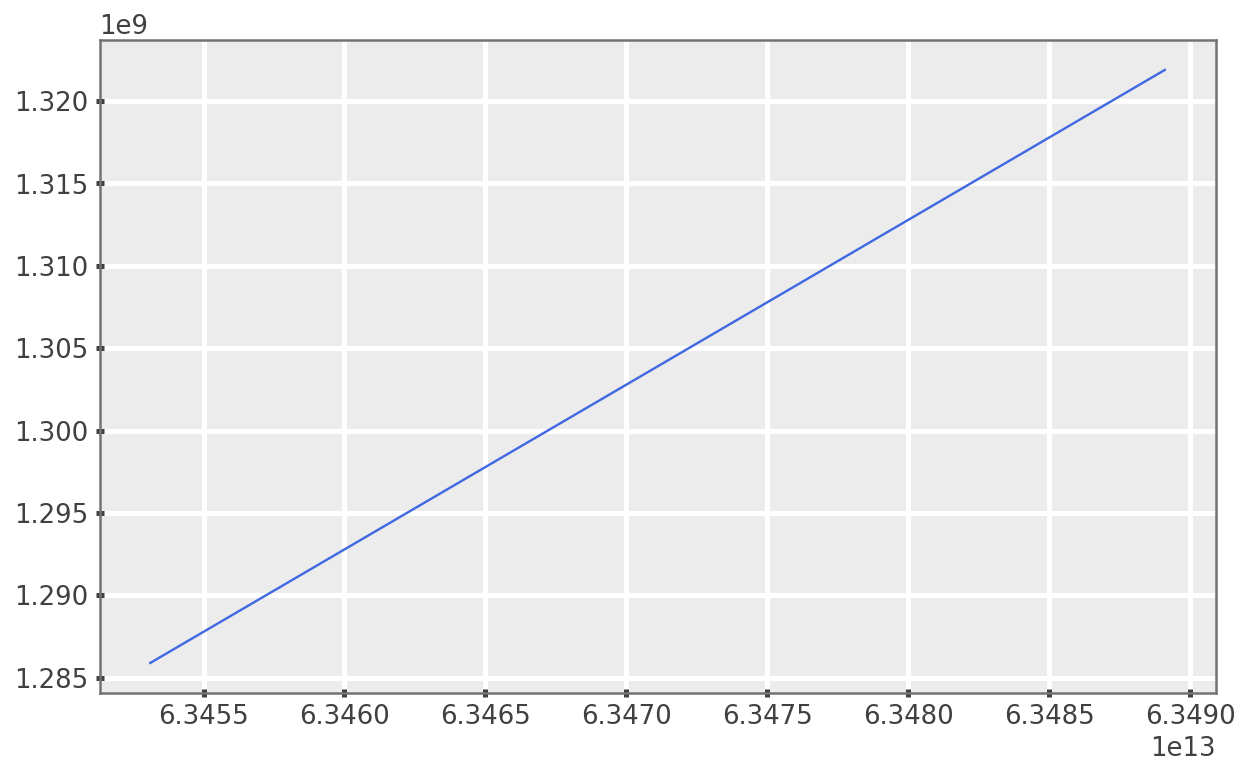

In [32]:
m,b = np.polyfit(TT.CDF, TT.UNX, 1)
print(m,b)
plt.plot(TT.CDF, TT.UNX)
print('UNX = {0}*CDF + {1}'.format(m,b))

def CDF_to_UNX(cdftime):
    """
    conversion is simple, BEWARE LEAP SECONDS!
    """
    return cdftime/1e3 - 62167219200.00285



1.15740740741e-08 1721059.5
JD = 1.1574074074075447e-08*CDF + 1721059.499999912


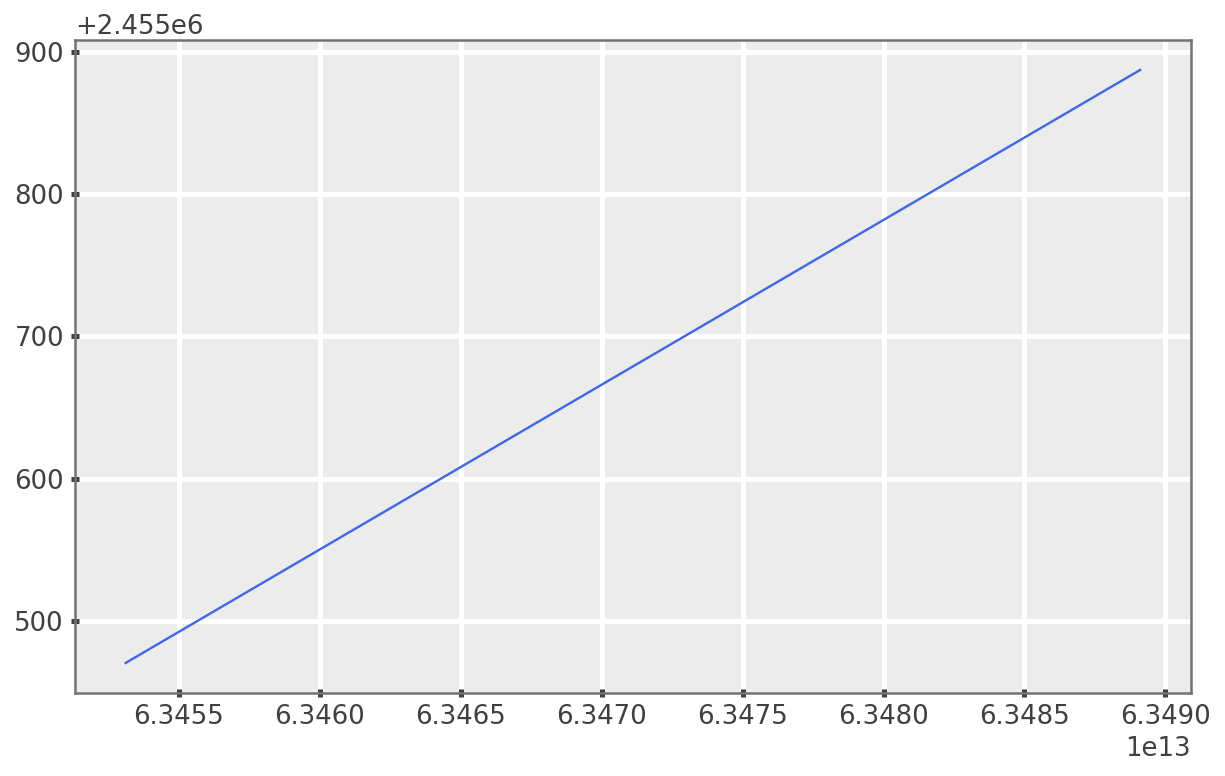

In [33]:
m,b = np.polyfit(TT.CDF, TT.JD, 1)
print(m,b)
plt.plot(TT.CDF, TT.JD)
print('JD = {0}*CDF + {1}'.format(m,b))

def CDF_to_JD(cdftime):
    """
    conversion is simple, BEWARE LEAP SECONDS!
    """
    return cdftime/1.15740740741e-08 + 1721059.5



In [34]:
'{0} JD'.format(TT.JD[0]), '{0}'.format(TT.ISO[0]), '{0}'.format(TT.ISO[0])

('2455470.5 JD', '2010-10-01T00:00:00', '2010-10-01T00:00:00')

In [35]:
%timeit spice.utc2et('{0} JD'.format(TT.JD[5]))
%timeit spice.utc2et('2016-12-10 00:00:30.809600')
%timeit spice.str2et('2016-12-10 00:00:30.809600')

14.5 µs ± 476 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
35.1 µs ± 3.15 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
39.1 µs ± 4.21 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


So the fastest way to get Spice times is from JD, so CDF->JD->Spice time

In [ ]:
def CDF_to_spice(cdftime):
    """
    BEWARE leap seconds!
    """
    jd = CDF_to_JD(cdftime)
    return np.asarray([spice.utc2et('{0} JD'.format(int(v))) for v in jd])
st = CDF_to_spice(TT.CDF[0:10])
print(st)
# issue here!

In [ ]:
tt = spt.Ticktock(TagTimes['Full_times_Ion'].flatten(), 'CDF')
seconds = tt.UNX
dt = pd.to_datetime(seconds,unit='s')

In [ ]:
dt

In [37]:
L1cdf = pycdf.CDF(l1fname)

TagTimes = dm.SpaceData()


# raw read the Epoch!!  This is faster and in milliseconds so no conversion needed
epoch16 = L1cdf.raw_var('Epoch_Ion_Cntr_H')[...]
# (3879,)
TagTimes['Epoch_Ion'] = dm.dmarray([pycdf.lib.epoch16_to_epoch(v) for v in epoch16])
TagTimes['Epoch_Ion'].attrs = L1cdf['Epoch_Ion_Cntr_H'].attrs.copy()

# if they are actually all the same no need to cycle through here
if (L1cdf['FRAME_subtime'][:, 0, 0] != L1cdf['FRAME_subtime'][:, 0, 0][0]).any():
    raise(NotImplementedError("L1cdf['FRAME_subtime'] has different values, not sure what to do"))

TagTimes['Epoch_Ion_FRAME_subtime'] = L1cdf['FRAME_subtime'][0, :, :].copy()
# (16, 72)
# L2cdf['FEDU'] CDF_REAL4 [3879, 5, 16, 72]
## multiply TagTimes['Epoch_Ion_FRAME_subtime'] by 1000 to make it a Epoch (milliseconds)
TagTimes['Epoch_Ion_FRAME_subtime'] *= 1000

## make the full times as Epochs
# Full times needs [epoch][sector][energy]  NO PIXEL!!
# factor of 4 in time by not having it be [pixel] also (8 to 2 seconds)
# also cdf is 140M smaller!!!
TagTimes['Full_times_Ion'] = np.empty((L1cdf['Ion_Cntr_H'].shape[0],
                                       L1cdf['Ion_Cntr_H'].shape[2],
                                       L1cdf['Ion_Cntr_H'].shape[3]), dtype=np.float64)

for ii, epoch in enumerate(TagTimes['Epoch_Ion']):
    TagTimes['Full_times_Ion'][ii] = epoch + TagTimes['Epoch_Ion_FRAME_subtime']


In [38]:
%timeit for ii, epoch in enumerate(TagTimes['Epoch_Ion']): TagTimes['Full_times_Ion'][ii] = epoch + TagTimes['Epoch_Ion_FRAME_subtime']


25.9 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
TagTimes['Full_times_Ion'].shape

(3474, 16, 72)

In [40]:
print(pycdf.lib.epoch_to_datetime(TagTimes['Full_times_Ion'][0,0,0]))
print(pycdf.lib.epoch_to_datetime(TagTimes['Full_times_Ion'][0,0,1]))
print(pycdf.lib.epoch_to_datetime(TagTimes['Full_times_Ion'][0,0,2]))

2016-12-10 00:00:30.809000
2016-12-10 00:00:30.819000
2016-12-10 00:00:30.828000


In [41]:
# change all the raw epoch values to a datetime
def epoch_to_dt(epoch):
    """
    use pycdf to change all the values to datetimes
    """
    dt = np.empty(epoch.shape, dtype=object) # to hold the datetimes
    for index, x in np.ndenumerate(TagTimes['Full_times_Ion']):
        dt[index] = pycdf.lib.epoch_to_datetime(x)
    return dt

def epoch_to_dt_v(epoch):
    """
    vectorized: use pycdf to change all the values to datetimes
    """
    #     dt = np.empty(epoch.shape, dtype=object) # to hold the datetimes
    dt = pycdf.lib.v_epoch_to_datetime(TagTimes['Full_times_Ion'])
    return dt

print(epoch_to_dt(TagTimes['Full_times_Ion'])[0,0,0:4])
print(epoch_to_dt_v(TagTimes['Full_times_Ion'])[0,0,0:4])

[datetime.datetime(2016, 12, 10, 0, 0, 30, 809000)
 datetime.datetime(2016, 12, 10, 0, 0, 30, 819000)
 datetime.datetime(2016, 12, 10, 0, 0, 30, 828000)
 datetime.datetime(2016, 12, 10, 0, 0, 30, 838000)]
[datetime.datetime(2016, 12, 10, 0, 0, 30, 809000)
 datetime.datetime(2016, 12, 10, 0, 0, 30, 819000)
 datetime.datetime(2016, 12, 10, 0, 0, 30, 828000)
 datetime.datetime(2016, 12, 10, 0, 0, 30, 838000)]


In [42]:
# %timeit epoch_to_dt(TagTimes['Full_times_Ion'])
# 30.4 s ± 2.46 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
# %timeit epoch_to_dt_v(TagTimes['Full_times_Ion'])
# 23.4 s ± 1.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

## Explore an Epoch to spice time conversion to avoid datetime alltogether

In [44]:
print(TagTimes['Full_times_Ion'][0,0,0], 
      pycdf.lib.epoch_to_datetime(TagTimes['Full_times_Ion'][0,0,0]))
dt = pycdf.lib.epoch_to_datetime(TagTimes['Full_times_Ion'][0,0,0])
print(dt.isoformat())

6.36485472308e+13 2016-12-10 00:00:30.809000
2016-12-10T00:00:30.809000


In [45]:
print(spice.str2et(dt.isoformat()))
print(spice.str2et('2016-12-10T00:00:30.809000'))
print(spice.str2et('2016-12-10T00:00:30.808000'))
print(spt.Ticktock('2016-12-10T00:00:30.808000', 'ISO'))

534600098.99231386
534600098.99231386
534600098.9913138
Ticktock( ['2016-12-10T00:00:30.808000'], dtype=ISO)


In [46]:
# differece should be constant
print(TagTimes['Full_times_Ion'][0,0,0] - spice.str2et(dt.isoformat()))

print(TagTimes['Full_times_Ion'][1,0,0] - 
      spice.str2et((pycdf.lib.epoch_to_datetime(TagTimes['Full_times_Ion'][1,0,0])).isoformat()))

6.36480126307e+13
6.36480126534e+13


In [47]:
pycdf.lib.epoch_to_datetime(TagTimes['Full_times_Ion'][1,0,0]).isoformat()

'2016-12-10T00:00:53.506000'

In [48]:
spice.str2et((pycdf.lib.epoch_to_datetime(TagTimes['Full_times_Ion'][1,0,0])).isoformat())

534600121.6893138

In [49]:

TagTimes['Full_times_Ion'][1,0,0]

63648547253506.602

In [50]:
ans = []

for i in range(20):
    df = (TagTimes['Full_times_Ion'][i,0,0] - 
      spice.str2et((pycdf.lib.epoch_to_datetime(TagTimes['Full_times_Ion'][i,0,0])).isoformat()))
    print(TagTimes['Full_times_Ion'][i,0,0], 
          pycdf.lib.epoch_to_datetime(TagTimes['Full_times_Ion'][i,0,0]).isoformat(), df)
    ans.append(df)

6.36485472308e+13 2016-12-10T00:00:30.809000 6.36480126307e+13
6.36485472535e+13 2016-12-10T00:00:53.506000 6.36480126534e+13
6.36485472762e+13 2016-12-10T00:01:16.203000 6.36480126761e+13
6.36485472989e+13 2016-12-10T00:01:38.899000 6.36480126987e+13
6.36485473216e+13 2016-12-10T00:02:01.596000 6.36480127214e+13
6.36485473443e+13 2016-12-10T00:02:24.293000 6.36480127441e+13
6.3648547367e+13 2016-12-10T00:02:46.989000 6.36480127668e+13
6.36485473897e+13 2016-12-10T00:03:09.685000 6.36480127894e+13
6.36485474124e+13 2016-12-10T00:03:32.382000 6.36480128121e+13
6.36485474578e+13 2016-12-10T00:04:17.776000 6.36480128575e+13
6.36485474805e+13 2016-12-10T00:04:40.472000 6.36480128801e+13
6.36485475259e+13 2016-12-10T00:05:25.865000 6.36480129255e+13
6.36485475486e+13 2016-12-10T00:05:48.562000 6.36480129481e+13
6.36485475713e+13 2016-12-10T00:06:11.258000 6.36480129708e+13
6.3648547594e+13 2016-12-10T00:06:33.955000 6.36480129935e+13
6.36485476167e+13 2016-12-10T00:06:56.652000 6.3648013016

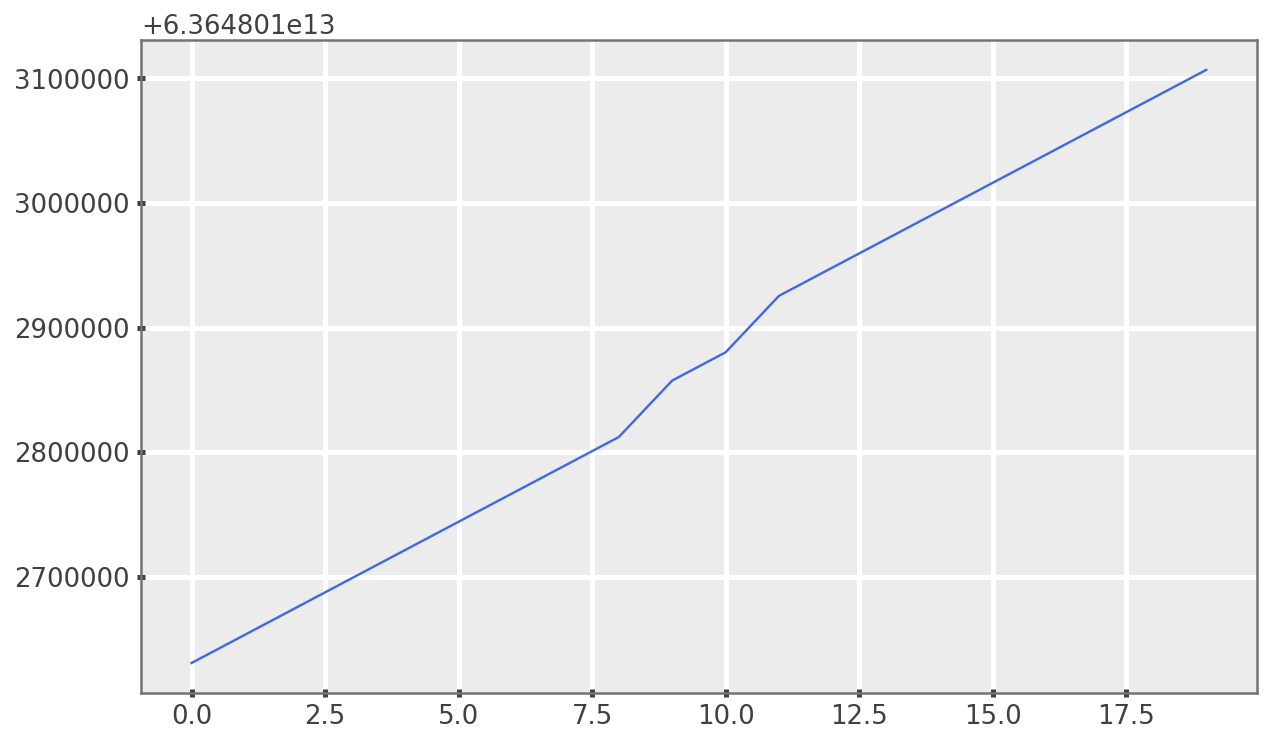

In [51]:
plt.plot(range(20), ans)


# Just get one end-to-end
The CDF to JD conversion in spacepy.time is likely fast enough to be usable here then the spice command of %timeit spice.utc2et('{0} JD'.format(TT.JD[5])) is the fastest from above



In [52]:
with pycdf.CDF(l1fname) as L1cdf:
    epoch16 = L1cdf.raw_var('Epoch_Ion_Cntr_H')[...]
    TagTimes['Epoch_Ion'] = dm.dmarray([pycdf.lib.epoch16_to_epoch(v) for v in epoch16])
    TagTimes['Epoch_Ion'].attrs = L1cdf['Epoch_Ion_Cntr_H'].attrs.copy()
    makeFullTimes_Ion(L1cdf, TagTimes)
TagTimes.tree(verbose=1)

+
|____Epoch_Ion (spacepy.datamodel.dmarray (3474,))
|____Epoch_Ion_FRAME_subtime (numpy.ndarray (16, 72))
|____Full_times_Ion (numpy.ndarray (3474, 16, 72))


## get the position and veloicity for all the Epoch_Ion times in the file


In [53]:
# make a JD array
Full_times_Ion_shape = TagTimes['Full_times_Ion'].shape
JD = spt.Ticktock(TagTimes['Full_times_Ion'].flatten(), 'CDF').JD


In [54]:
np.unique(JD).shape, JD.shape

((4002048,), (4002048,))

In [55]:
# %timeit '{0} JD'.format(JD[0])
# %timeit '{0}'.format(JD[0]) + ' JD'
# %timeit str(JD[0]) + ' JD'
# 332 ns ± 5.14 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
# 410 ns ± 20.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
# 1.25 µs ± 46.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)

In [81]:

# spicetimes = np.empty(len(JD), dtype=float)
positions = np.empty((len(JD), 3), dtype=float)
velocities = np.empty((len(JD), 3), dtype=float)
rotations = np.empty((len(JD), 3, 3), dtype=float)

# lightTimes = np.empty((len(Full_times_Ion)), dtype=float)

for ii, val in enumerate(tqdm.tqdm(JD)):
    spicetime = spice.utc2et('{0} JD'.format(val)) 
    pv, lightTime = spice.spkezr('RBSP_A', spicetime, 'J2000', 'NONE', 'EARTH')
    rotations[ii] = spice.pxform('J2000', 'RBSPA_SCIENCE', spicetime)
    positions[ii] = pv[:3]
    velocities[ii] = pv[3:]
    
    
    

100%|██████████| 4002048/4002048 [05:58<00:00, 11160.90it/s]


In [92]:
positions = positions.reshape((*Full_times_Ion_shape, 3))
velocities = velocities.reshape((*Full_times_Ion_shape, 3))
rotations = rotations.reshape((*Full_times_Ion_shape, 3, 3))

print(positions.shape, velocities.shape, rotations.shape)

(3474, 16, 72, 3) (3474, 16, 72, 3) (3474, 16, 72, 3, 3)


### Explore one energy sweep
Slow change, RBSPA frame

In [83]:
positions[100,0].shape

(72, 3)

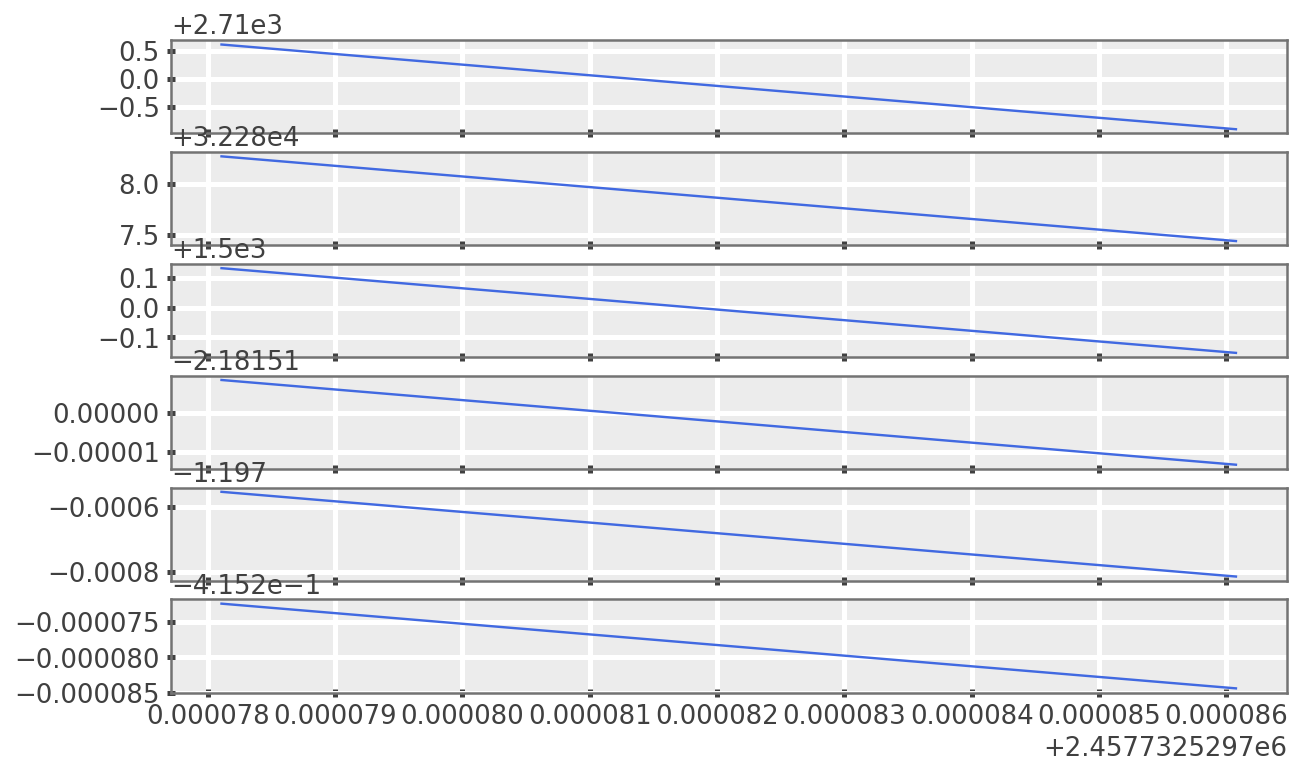

In [84]:
fig, ax = plt.subplots(nrows=6, ncols=1, sharex=True)

XX = JD.reshape(Full_times_Ion_shape)[100,0]

ax[0].plot(XX, positions[100,0,:,0], label='Xpos')
ax[1].plot(XX, positions[100,0,:,1], label='Ypos')
ax[2].plot(XX, positions[100,0,:,2], label='Zpos')

ax[3].plot(XX, velocities[100,0,:,0], label='Xvel')
ax[4].plot(XX, velocities[100,0,:,1], label='Yvel')
ax[5].plot(XX, velocities[100,0,:,2], label='Zvel')


### Explore one spin at one energy
Slow change, RBSPA frame

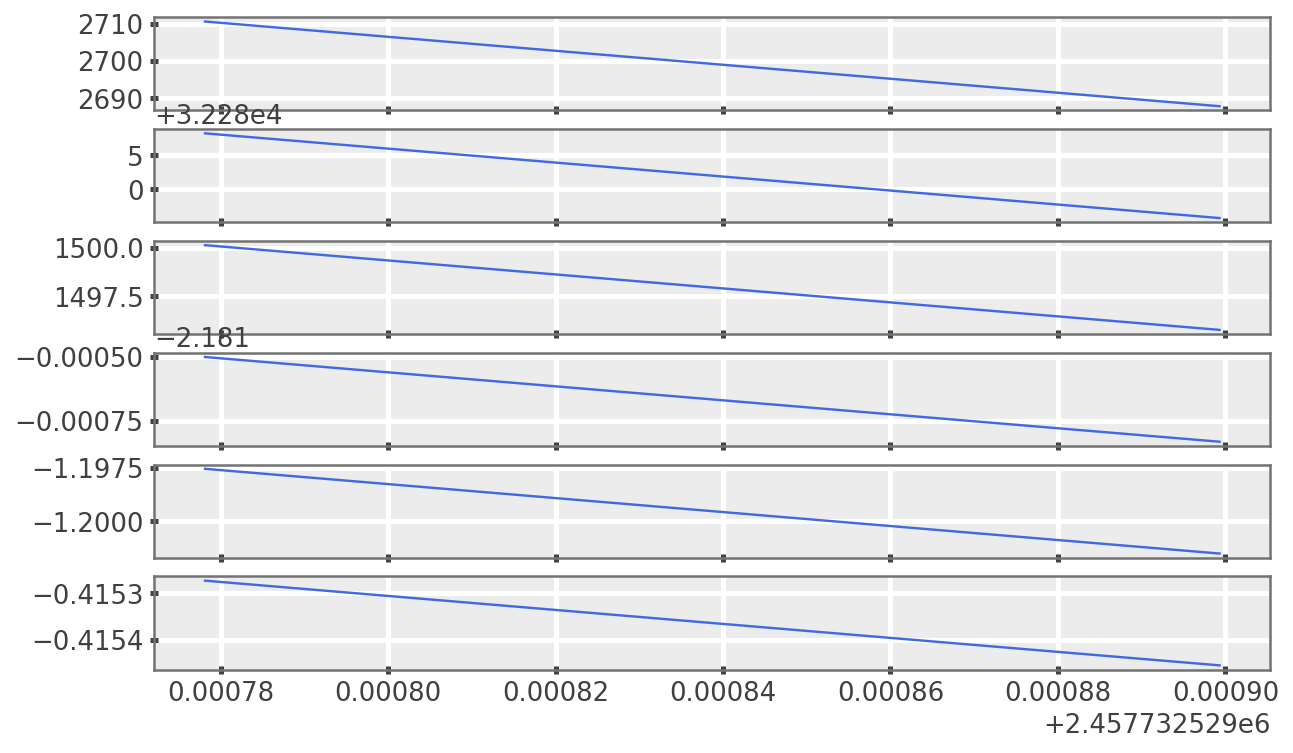

In [85]:
fig, ax = plt.subplots(nrows=6, ncols=1, sharex=True)

XX = JD.reshape(Full_times_Ion_shape)[100,:,0]

ax[0].plot(XX, positions[100,:,0,0], label='Xpos')
ax[1].plot(XX, positions[100,:,0,1], label='Ypos')
ax[2].plot(XX, positions[100,:,0,2], label='Zpos')

ax[3].plot(XX, velocities[100,:,0,0], label='Xvel')
ax[4].plot(XX, velocities[100,:,0,1], label='Yvel')
ax[5].plot(XX, velocities[100,:,0,2], label='Zvel')


In [86]:
positions[100,:,0].shape

(16, 3)

In [87]:
positions[100,:,0]

array([[  2710.6101985 ,  32288.26665882,   1500.13376552],
       [  2709.08732388,  32287.43057657,   1499.84386712],
       [  2707.56433397,  32286.59425568,   1499.55394116],
       [  2706.04132865,  32285.75775096,   1499.26400667],
       [  2704.51840779,  32284.92111725,   1498.97408264],
       [  2702.99537166,  32284.08424483,   1498.68413108],
       [  2701.47233679,  32283.24719768,   1498.39417414],
       [  2699.94935311,  32282.41000326,   1498.10422135],
       [  2698.42628747,  32281.57258836,   1497.81424734],
       [  2696.90318982,  32280.73498039,   1497.52426163],
       [  2695.38016003,  32279.89723429,   1497.23428324],
       [  2693.85704831,  32279.05926765,   1496.94428364],
       [  2692.33390459,  32278.22110791,   1496.65427234],
       [  2690.81084541,  32277.38281919,   1496.36427153],
       [  2689.28767102,  32276.54429153,   1496.07424317],
       [  2687.7644813 ,  32275.70557991,   1495.78420628]])

In [88]:
velocities[100,:,0].shape

(16, 3)

In [89]:
velocities[100,:,0]

array([[-2.18150156, -1.19755327, -0.41527235],
       [-2.18152366, -1.19781656, -0.41528458],
       [-2.18154574, -1.19807988, -0.41529681],
       [-2.18156782, -1.19834321, -0.41530904],
       [-2.18158988, -1.19860655, -0.41532127],
       [-2.18161193, -1.19886992, -0.4153335 ],
       [-2.18163398, -1.1991333 , -0.41534572],
       [-2.18165601, -1.19939669, -0.41535795],
       [-2.18167803, -1.19966011, -0.41537017],
       [-2.18170004, -1.19992355, -0.41538239],
       [-2.18172204, -1.20018699, -0.41539461],
       [-2.18174403, -1.20045045, -0.41540683],
       [-2.18176601, -1.20071394, -0.41541905],
       [-2.18178798, -1.20097743, -0.41543127],
       [-2.18180994, -1.20124095, -0.41544348],
       [-2.18183189, -1.20150449, -0.4154557 ]])

## Take one spin at an energy and rotate it

In [93]:
rotations.shape, velocities.shape

((3474, 16, 72, 3, 3), (3474, 16, 72, 3))

In [99]:
# get the velocity in the RBSPA_SCIENCE coords
vel_sci = np.einsum('ij,ijk->ik',velocities[100,:,0],rotations[100,:,0])
# then get this for each HOPE pixel
pixel_velocities = np.empty((len(vel_sci), 3, 5), dtype=float)
for pixel in tqdm.tqdm(range(5)):
    pixel_velocities[:,:,pixel] = np.asarray(vel_sci*rots[pixel])
pixel_velocities.shape

100%|██████████| 5/5 [00:00<00:00, 13374.69it/s]


(16, 3, 5)

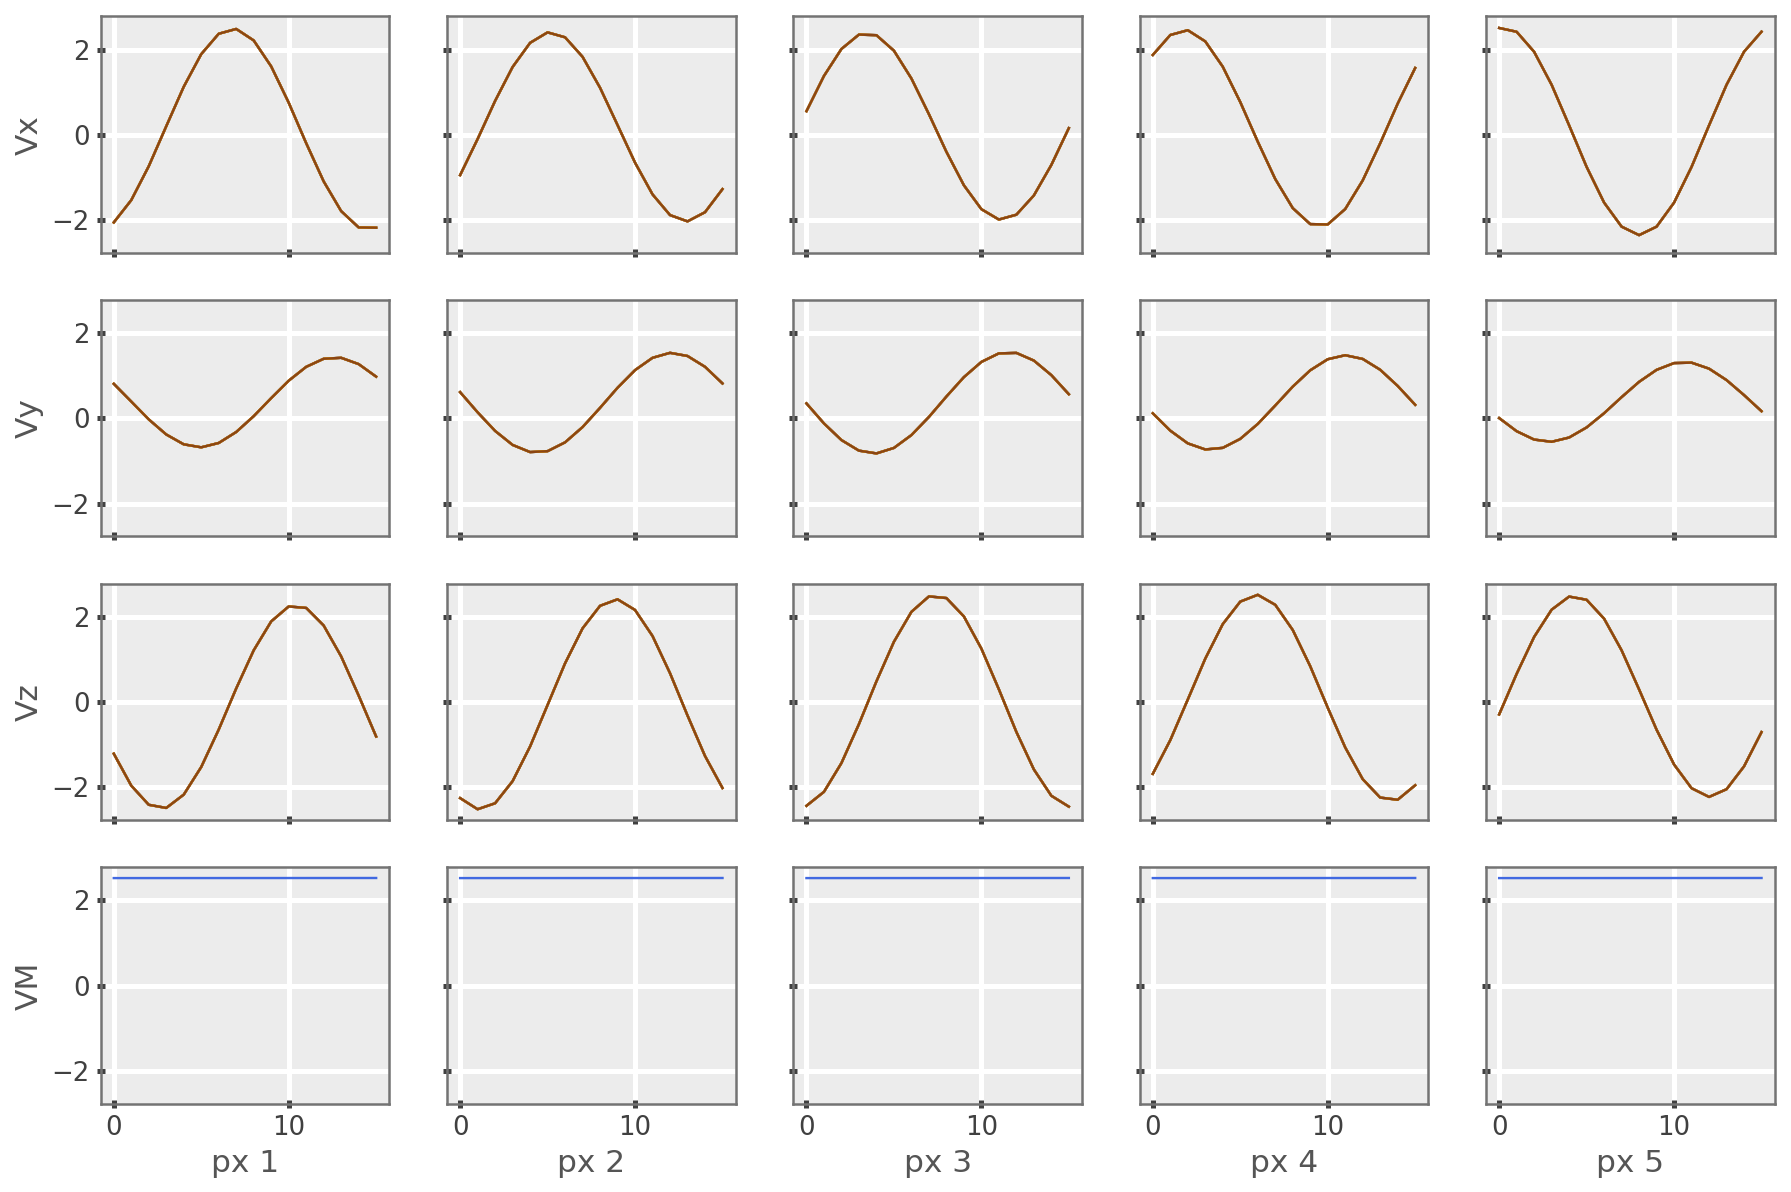

In [103]:

fig, ax = plt.subplots(ncols=5, nrows=4, sharex=True, sharey=True, figsize=(15,10))
components = ('x', 'y', 'z', 'M')

for comp in range(4):
    for pix in range(5):
        if comp < 3:
            ax[comp][pix].plot(pixel_velocities[:,comp,pix])
            ax[comp][pix].plot(pixel_velocities[:,comp,pix])
            ax[comp][pix].plot(pixel_velocities[:,comp,pix])
            ax[comp][pix].plot(pixel_velocities[:,comp,pix])
            ax[comp][pix].plot(pixel_velocities[:,comp,pix])
        else:
            ax[comp][pix].plot(norm(pixel_velocities[:,:,pix], axis=1))
        ax[-1][pix].set_xlabel('px {0}'.format(pix+1))
    ax[comp][0].set_ylabel('V{0}'.format(components[comp]))


### Get the componet of the velocity into X and then use that to correct the energy

kms_to_e()

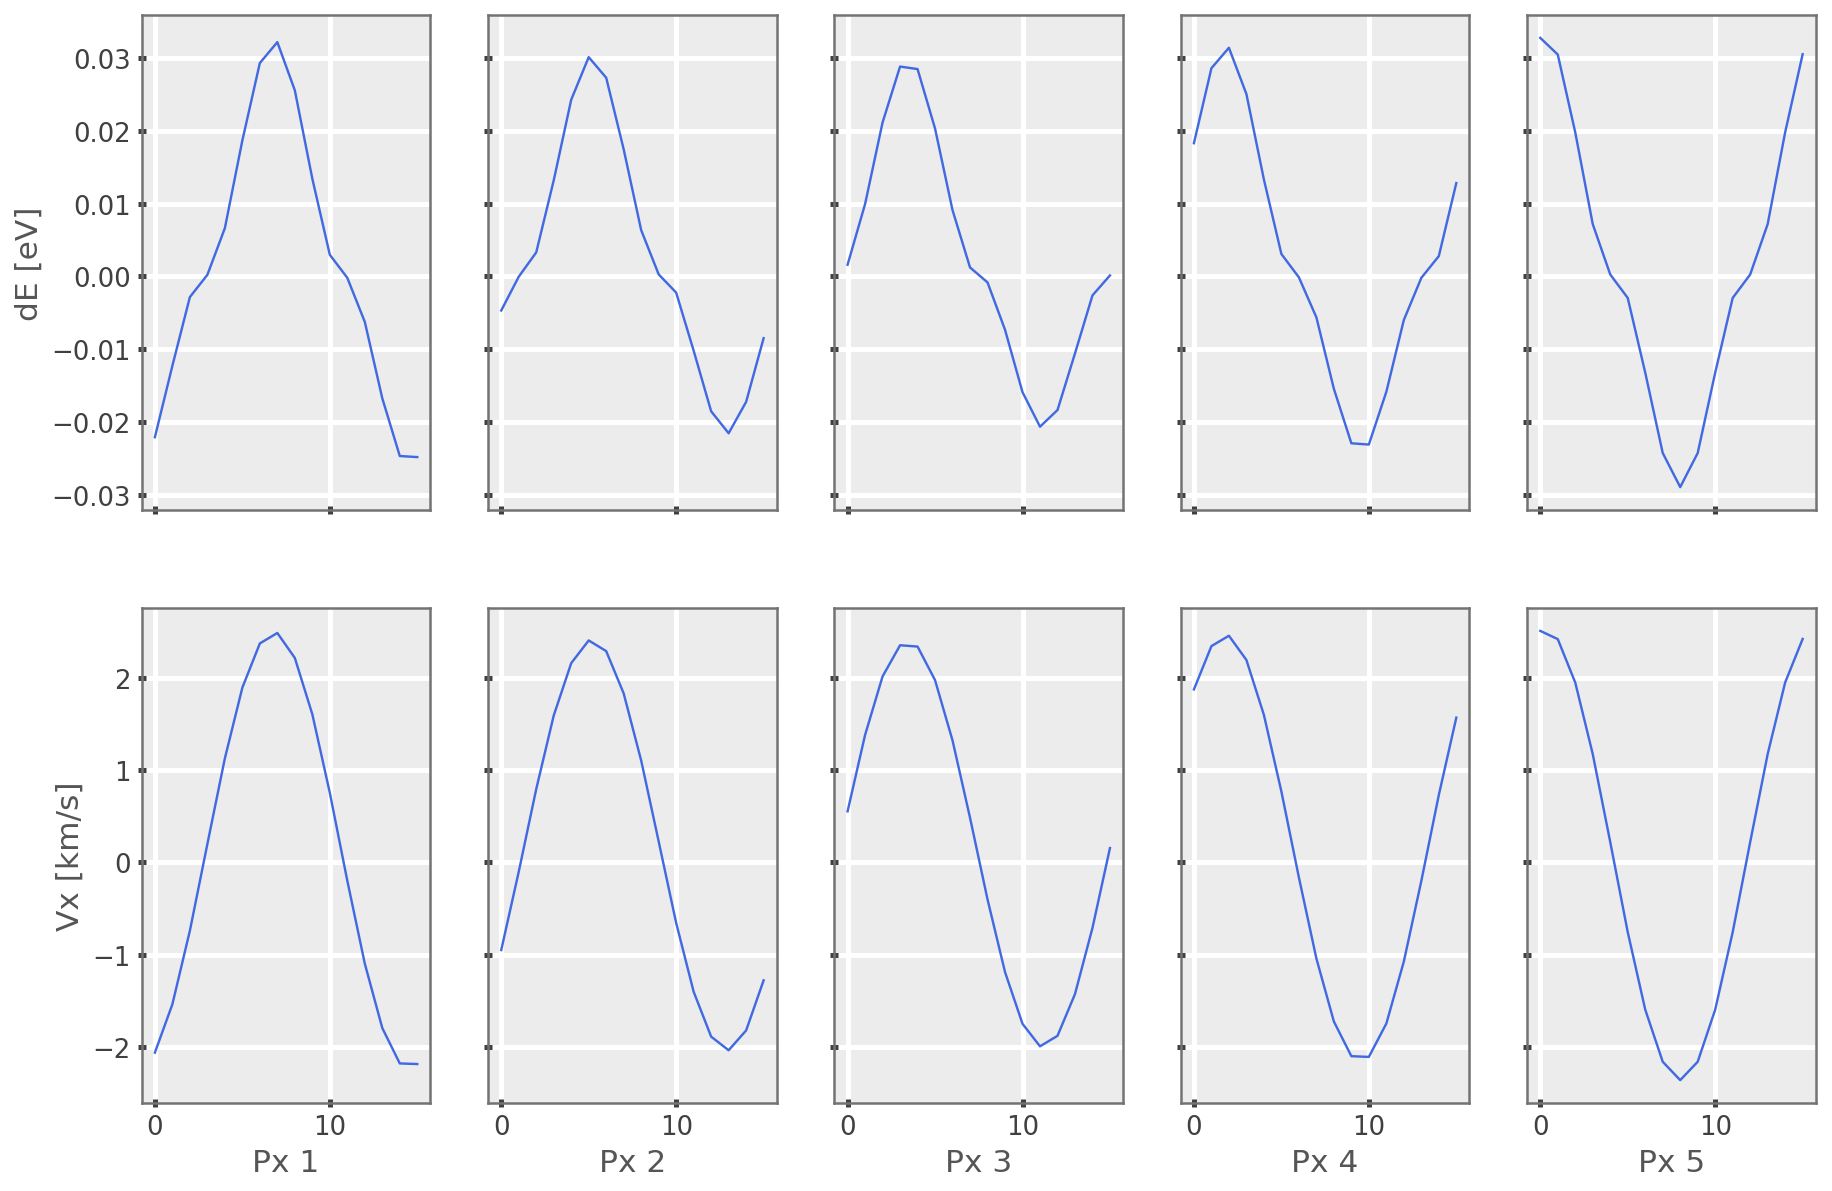

In [126]:
dE = np.empty((16,5), dtype=float)
for pix in range(5):
    dE[:,pix] = kms_to_e(pixel_velocities[:,0,pix])

fig, ax = plt.subplots(ncols=5, nrows=2, sharex=True, sharey='row', figsize=(15,10))
components = ('Ecorr', 'Vx',)

for pix in range(5):
    ax[0][pix].plot(dE[:,pix])
    ax[1][pix].plot(pixel_velocities[:,0,pix])
ax[0][0].set_ylabel('dE [eV]')
ax[1][0].set_ylabel('Vx [km/s]')
for comp in range(5):
    ax[1][comp].set_xlabel('Px {0}'.format(comp+1))


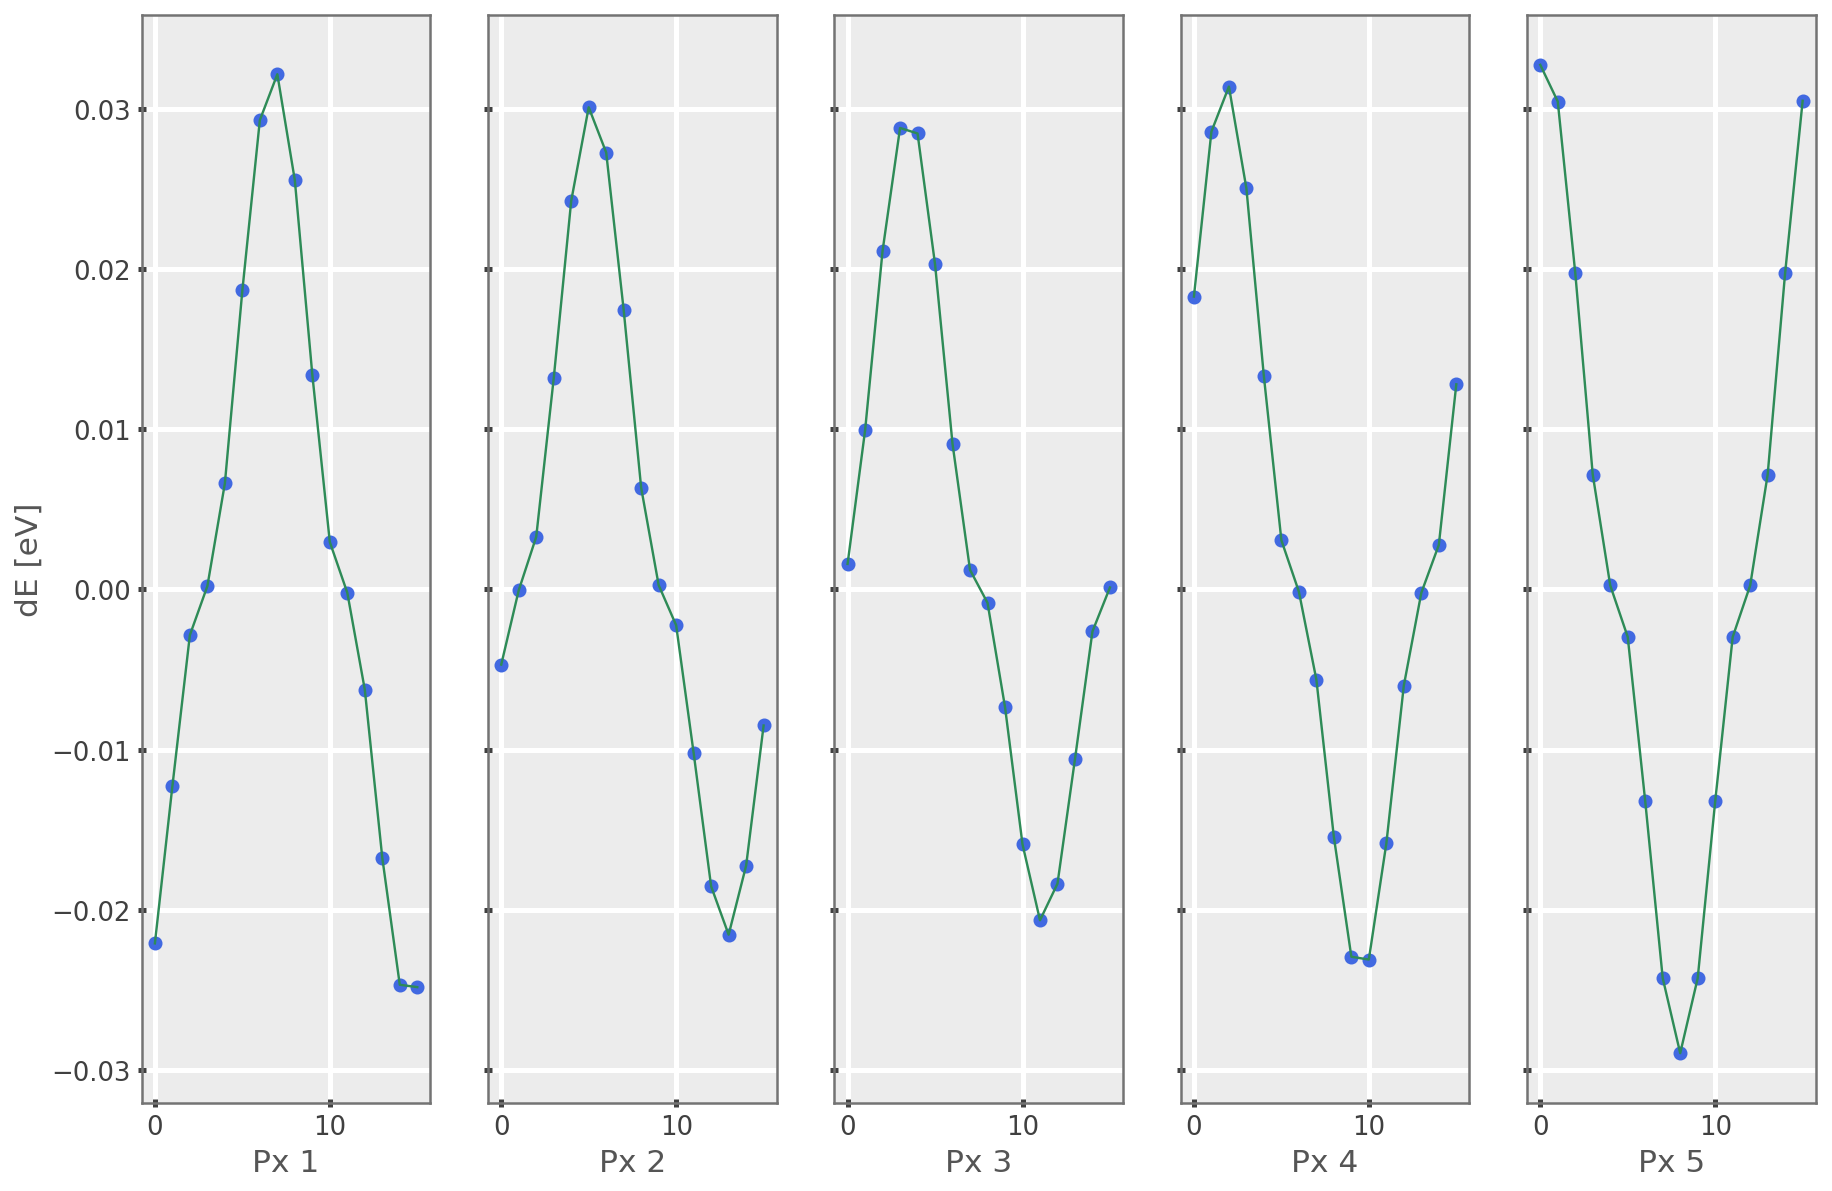

In [124]:
from scipy.signal import savgol_filter

fig, ax = plt.subplots(ncols=5, nrows=1, sharex=True, sharey=True, figsize=(15,10))
components = ('Ecorr', 'Vx',)

for pix in range(5):
    ax[pix].plot(dE[:,pix], 'o')
    ax[pix].plot(savgol_filter(dE[:,pix], 3, 2, mode='nearest'))
ax[0].set_ylabel('dE [eV]')
for comp in range(5):
    ax[comp].set_xlabel('Px {0}'.format(comp+1))